In [2]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.visualization import plot_histogram, plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere, plot_bloch_vector, plot_state_city, plot_bloch_multivector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit import assemble
import qiskit.quantum_info as qi
from qiskit.circuit import Gate
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt 
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ

In [422]:
IBMQ.load_account() # Load account from disk
IBMQ.providers()
provider = IBMQ.get_provider(hub='ibm-q', group='open')
#backend = provider.get_backend('ibmq_vigo')

available_cloud_backends = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

from qiskit.providers.ibmq import least_busy

#small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   #and not x.configuration().simulator)
# small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 6
#                                     and not x.configuration().simulator
#                                     and x.status().operational==True)
print('\nHere is the list of cloud backends that are available to you:')
for i in available_cloud_backends: print(i)
print(least_busy(available_cloud_backends))




ibmqfactory.load_account:WARNING:2021-09-10 09:06:31,881: Credentials are already in use. The existing account in the session will be replaced.



Here is the list of cloud backends that are available to you:
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
ibmq_manila
ibmq_bogota


In [425]:
qcomp = provider.get_backend('ibmq_bogota')

In [426]:

aer_sim = Aer.get_backend('aer_simulator')

In [427]:

######
# Create a custum gate that is affected by error 
# (in this case an identity gate on 3 qubits that might fail and apply a x error on one of the qubits)
######
ident3 = qi.Operator([  [1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]  ])
qe=QuantumCircuit(3, name='error')
qe.unitary(ident3, [0, 1, 2], label='error')

In [428]:
#######
# Create the quantum circuit with the initial state
#######
qc_3qx = QuantumRegister(3)
qc_3qx = QuantumCircuit(qc_3qx)
initial_state = [1/np.sqrt(3), np.sqrt(2)/np.sqrt(3)]  
initial_state = [1, 0]  
qc_3qx.initialize(initial_state, 0) # Initialize the 0th qubit in the state `initial_state`
qc_3qx.barrier()


In [429]:
###Encoding procedure
qc_3qx.cx(0,1)
qc_3qx.cx(0,2)
qc_3qx.barrier()


In [430]:

qc_3qx.append(qe,[0,1,2])

In [431]:

qc_3qx.x(2)
qc_3qx.x(1)
qc_3qx.x(0)
qc_3qx.x(2)
qc_3qx.x(1)
qc_3qx.x(0)
qc_3qx.x(2)
qc_3qx.x(1)
qc_3qx.x(0)
qc_3qx.x(2)
qc_3qx.x(1)
qc_3qx.x(0)
qc_3qx.x(2)
qc_3qx.x(1)
qc_3qx.x(0)
qc_3qx.x(2)
qc_3qx.x(1)
qc_3qx.x(0)
#qc_3qx.draw('mpl')
#plt.show()

In [432]:

#####
#Create the error model
#####
p_error = 0.1 #Error probability
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
bit_flip1=bit_flip.tensor(bit_flip)
bit_flip2=bit_flip1.tensor(bit_flip)
#print(bit_flip2)
#print("hey kraus",bit_flip_kraus)
######
#Set error basis
######
noise_model = NoiseModel(['unitary'])
noise_model.add_all_qubit_quantum_error(bit_flip2, 'error')

In [433]:
k=2
anc=QuantumRegister(k, 'aux') ### Ancilla qubit
qc_3qx.add_register(anc)


In [434]:
qc_3qx.cx(0,3)
qc_3qx.cx(1,3)
qc_3qx.cx(1,4)
qc_3qx.cx(2,4)
qc_3qx.barrier()
#qc_3qx.measure(anc[0],cr[0])
#qc_3qx.measure(anc[1],cr[1])
#qc_3qx.barrier()

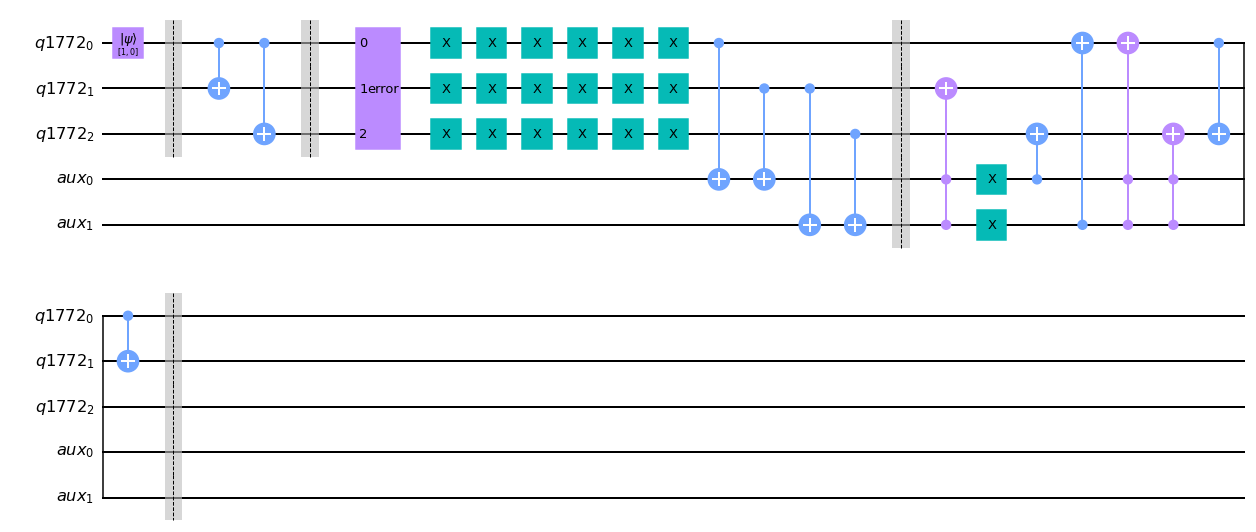

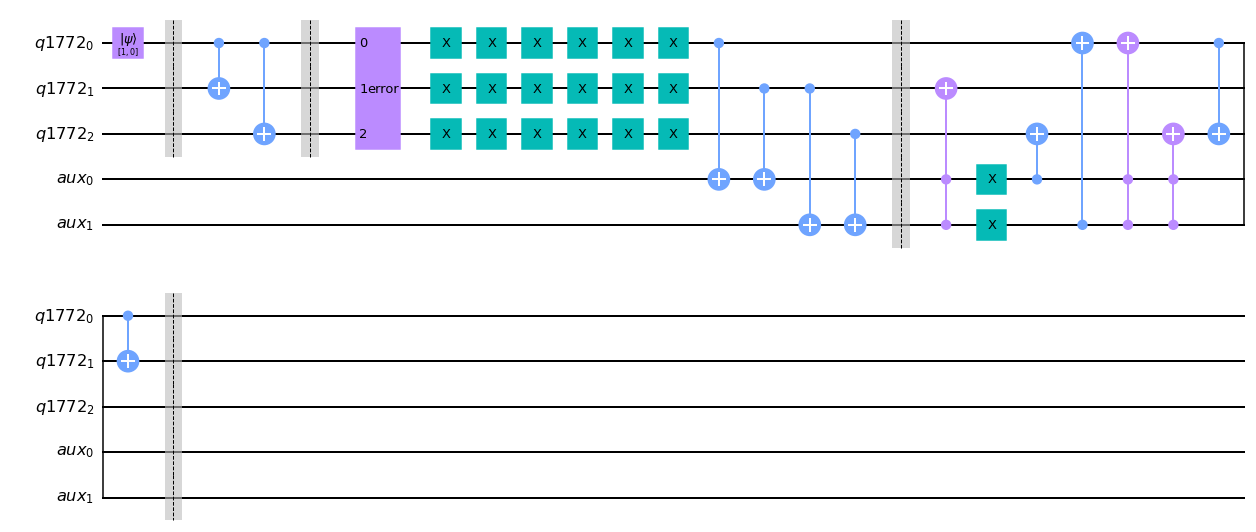

In [435]:
###
#Recovery 
###
#qc_3qx.x(0).c_if(cr, 1) ###condition is in binary
#qc_3qx.x(1).c_if(cr, 3)
#qc_3qx.x(2).c_if(cr, 2)
#qc_3qx.barrier() ##Condition with classical register is not supported in real quantum computer
#####
#Recovery for real quantum computer using only ancillas
#####
qc_3qx.ccx(3,4,1)
qc_3qx.x(3)
qc_3qx.x(4)
qc_3qx.cx(3,2)
qc_3qx.cx(4,0)
qc_3qx.ccx(3,4,0)
qc_3qx.ccx(3,4,2)
###
#Decoding
###
qc_3qx.cx(0,2)
qc_3qx.cx(0,1)

qc_3qx.barrier()
qc_3qx.draw('mpl')

In [436]:
###
# Simulation
###
#qc_3qx.draw('mpl', scale=0.8, filename='3bitflipcode.png')
cr2=ClassicalRegister(3, 'outcome')
qc_3qx.add_register(cr2)
qc_3qx.measure([0,1,2],[0,1,2])

In [227]:
qc_3qx.draw()

┌─────────────────┐ ░            ░ ┌────────┐┌───┐┌───┐┌───┐┌───┐»
      q_0: ┤ Initialize(1,0) ├─░───■────■───░─┤0       ├┤ X ├┤ X ├┤ X ├┤ X ├»
           └─────────────────┘ ░ ┌─┴─┐  │   ░ │        │├───┤├───┤├───┤├───┤»
      q_1: ────────────────────░─┤ X ├──┼───░─┤1 error ├┤ X ├┤ X ├┤ X ├┤ X ├»
                               ░ └───┘┌─┴─┐ ░ │        │├───┤├───┤├───┤├───┤»
      q_2: ────────────────────░──────┤ X ├─░─┤2       ├┤ X ├┤ X ├┤ X ├┤ X ├»
                               ░      └───┘ ░ └────────┘└───┘└───┘└───┘└───┘»
    aux_0: ─────────────────────────────────────────────────────────────────»
                                                                            »
    aux_1: ─────────────────────────────────────────────────────────────────»
                                                                            »
outcome: 3/═════════════════════════════════════════════════════════════════»
                                                                            »
«           ┌───┐┌───┐                     ░                ┌───┐┌───┐     »
«      q_0: ┤ X ├┤ X ├──■──────────────────░────────────────┤ X ├┤ X ├─────»
«           ├───┤├───┤  │                  ░ ┌───┐          └─┬─┘└─┬─┘     »
«      q_1: ┤ X ├┤ X ├──┼────■────■────────░─┤ X ├────────────┼────┼───────»
«           ├───┤├───┤  │    │    │        ░ └─┬─┘     ┌───┐  │    │  ┌───┐»
«      q_2: ┤ X ├┤ X ├──┼────┼────┼────■───░───┼───────┤ X ├──┼────┼──┤ X ├»
«           └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░   │  ┌───┐└─┬─┘  │    │  └─┬─┘»
«    aux_0: ──────────┤ X ├┤ X ├──┼────┼───░───■──┤ X ├──■────┼────■────■──»
«                     └───┘└───┘┌─┴─┐┌─┴─┐ ░   │  ├───┤       │    │    │  »
«    aux_1: ────────────────────┤ X ├┤ X ├─░───■──┤ X ├───────■────■────■──»
«                               └───┘└───┘ ░      └───┘                    »
«outcome: 3/═══════════════════════════════════════════════════════════════»
«                                                                          »
«                      ░ ┌─┐      
«      q_0: ──■────■───░─┤M├──────
«             │  ┌─┴─┐ ░ └╥┘┌─┐   
«      q_1: ──┼──┤ X ├─░──╫─┤M├───
«           ┌─┴─┐└───┘ ░  ║ └╥┘┌─┐
«      q_2: ┤ X ├──────░──╫──╫─┤M├
«           └───┘      ░  ║  ║ └╥┘
«    aux_0: ───────────░──╫──╫──╫─
«                      ░  ║  ║  ║ 
«    aux_1: ───────────░──╫──╫──╫─
«                      ░  ║  ║  ║ 
«outcome: 3/══════════════╩══╩══╩═
«                         0  1  2

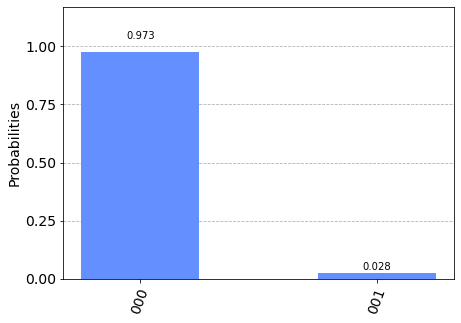

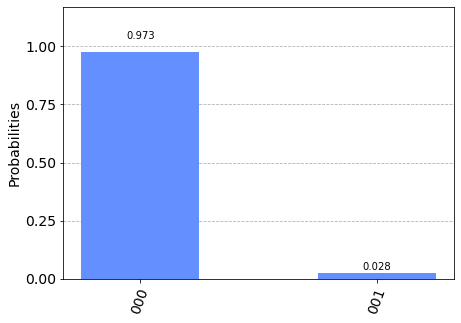

In [437]:
counts=execute(qc_3qx,backend = aer_sim, noise_model=noise_model, shots=10000).result().get_counts()
plot_histogram(counts)

In [442]:
####Simulation on real quantum computer

job= execute(qc_3qx,backend = qcomp)

In [443]:
job_monitor(job)

Job Status: job incurred error    


In [440]:
result = job.result()
device_counts = result.get_counts(qc_3qx) 
plot_histogram(device_counts)

IBMQJobFailureError: 'Unable to retrieve result for job 613b044935e37ea88e2ef137. Job has failed: Generic error invoking the remote services. Error code: 422.'

In [450]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circ , state_label = complete_meas_cal(qr=qc_3qx.qregs[0], circlabel= 'measurement_err_cal')


In [451]:
cal_job=execute(qc_3qx, backend= qcomp, shots=1024, optimization_level=0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_result = cal_job.result()

613b04e68d80c518a6d44379
Job Status: job incurred error    


IBMQJobFailureError: 'Unable to retrieve result for job 613b04e68d80c518a6d44379. Job has failed: Generic error invoking the remote services. Error code: 422.'

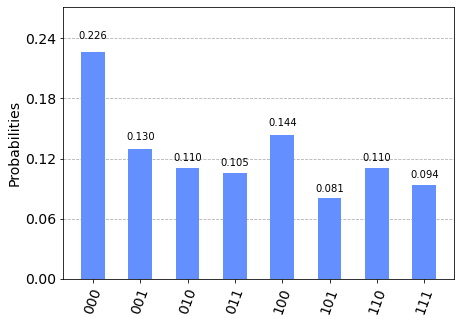

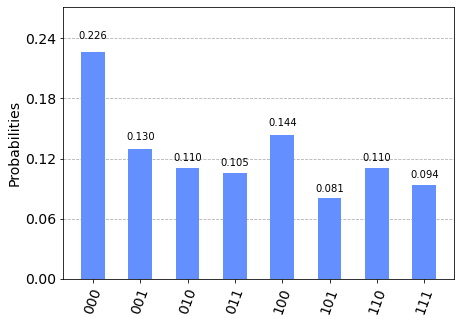

In [399]:
plot_histogram(cal_result.get_counts())

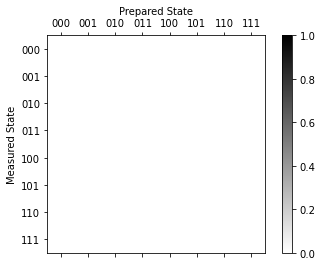

In [408]:
meas_fitter = CompleteMeasFitter(cal_result , state_label)
meas_fitter.plot_calibration()

In [401]:
meas_filter = meas_fitter.filter
print(meas_filter)
mitigated_result = meas_filter.apply(cal_result)


In [405]:
mitigated_counts = mitigated_result.get_counts(qc_3qx)

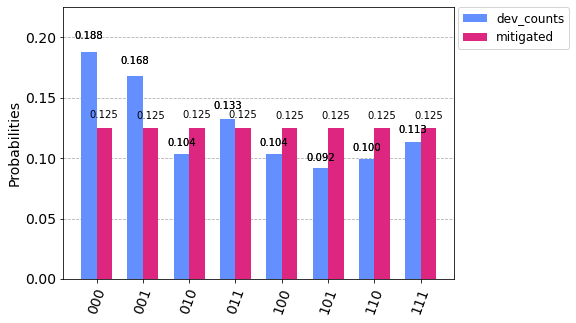

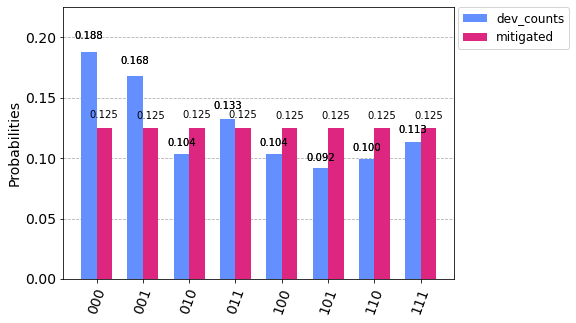

In [406]:
plot_histogram([device_counts, mitigated_counts], legend=['dev_counts','mitigated'])